In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sweetviz
import folium
import geopandas
from geopy.distance import geodesic
from datetime import datetime

In [2]:
data = pd.read_csv('../../../Desktop/SamX/Bike_Study_Files/big_raw.csv')
data.shape

(5733451, 13)

In [10]:
# Counting unique stations for both start and end stations
unique_start_stations = data['start_station_name'].nunique()
unique_end_stations = data['end_station_name'].nunique()

# Calculating the total number of unique stations
# Assuming a station can be either a start or an end station
unique_stations = data[['start_station_name', 'end_station_name']].stack().nunique()

unique_start_stations, unique_end_stations, unique_stations

(894, 902, 1001)

#### Note:
For the purposes of this analysis, I do not need to be crunching through all 5 million rows of data. A sample of 50,000 is more than enough, and possibly too much for the heatmapping functions. I may need to tweak the parameters of the heatmap, or further restrict the sample size later down the road

In [3]:
data = data.sample(n=50000, replace=False, random_state=42)
data.shape

(50000, 13)

In [4]:
# Convert 'started_at' and 'ended_at' to datetime objects
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

# Calculate ride duration in minutes
data['ride_duration'] = (data['ended_at'] - data['started_at']).dt.total_seconds() / 60

# Additional columns for temporal analysis
data['start_date'] = data['started_at'].dt.date
data['start_hour'] = data['started_at'].dt.hour
data['day_of_week'] = data['started_at'].dt.day_name()
data['week_of_year'] = data['started_at'].dt.isocalendar().week

# Preview the data with new columns
data[['ride_id', 'rideable_type', 'member_casual', 'started_at', 'ended_at', 'ride_duration', 'start_date', 'start_hour', 'day_of_week', 'week_of_year']].head()

,ride_id,rideable_type,member_casual,started_at,ended_at,ride_duration,start_date,start_hour,day_of_week,week_of_year
3479634,DF3F95B75B6DFBBC,electric_bike,member,2022-08-09 09:54:27,2022-08-09 09:57:36,3.150000,2022-08-09,9,Tuesday,32
2954009,E62A501C91C9283A,electric_bike,casual,2022-07-05 17:32:36,2022-07-05 17:39:24,6.800000,2022-07-05,17,Tuesday,27
4233289,2332C4F5E2EE3457,classic_bike,member,2022-09-15 17:05:35,2022-09-15 17:20:22,14.783333,2022-09-15,17,Thursday,37
4282455,063065272EF72853,classic_bike,member,2022-09-08 13:51:19,2022-09-08 13:55:26,4.116667,2022-09-08,13,Thursday,36
2265302,AFC7A810123AB8EB,classic_bike,casual,2022-06-19 11:36:21,2022-06-19 12:39:10,62.816667,2022-06-19,11,Sunday,24


In [5]:
data.shape

(50000, 18)

C:\Users\sshanks\AppData\Local\Temp\ipykernel_18356\3813941866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_bikes_members['day_of_week'] = classic_bikes_members['started_at'].dt.dayofweek
C:\Users\sshanks\AppData\Local\Temp\ipykernel_18356\3813941866.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_bikes_members_weekdays['hour_of_day'] = classic_bikes_members_weekdays['started_at'].dt.hour


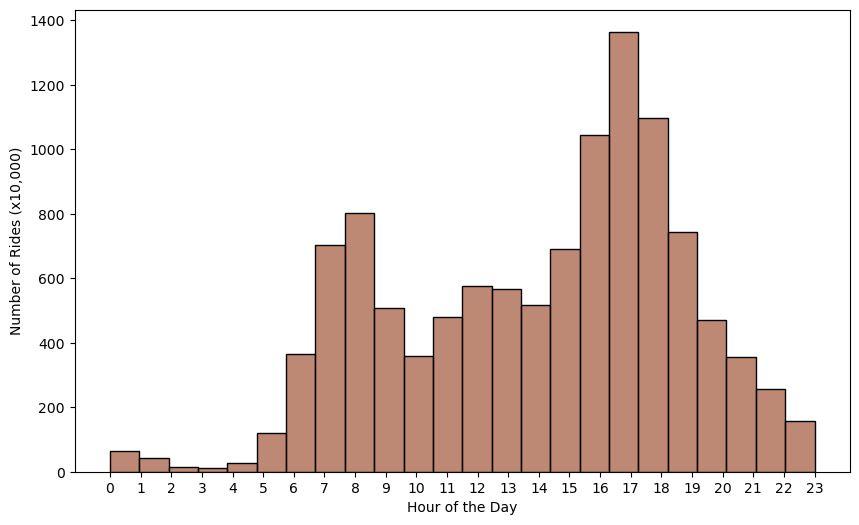

In [13]:
# Filter for only classic bikes used by members
classic_bikes_members = data[(data['rideable_type'] == 'classic_bike') & (data['member_casual'] == 'member')]

# Filter for Monday to Friday
classic_bikes_members['day_of_week'] = classic_bikes_members['started_at'].dt.dayofweek
classic_bikes_members_weekdays = classic_bikes_members[classic_bikes_members['day_of_week'] < 5]

# Extract hour of day
classic_bikes_members_weekdays['hour_of_day'] = classic_bikes_members_weekdays['started_at'].dt.hour

# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(classic_bikes_members_weekdays['hour_of_day'], bins=24, kde=False, color='#a76046')
#plt.title('Usage of Classic Bikes by Members (Monday-Friday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides (x10,000)')
plt.xticks(range(0, 24))
plt.grid(False)
plt.show()



This histogram shows that there is clearly a bias toward afternoon rides among members. The strong spikes in the morning and late afternoon would be indicative of a strong culture of bicycyle-commuting. 

Testable Hypothesis: The significantly stronger spike in the afternoon might lead to a geographical re-distribution of classic cycles from the central areas of Chicago outward toward the more residential areas.

C:\Users\sshanks\AppData\Local\Temp\ipykernel_18356\471480448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_bikes_casual['day_of_week'] = classic_bikes_casual['started_at'].dt.dayofweek
C:\Users\sshanks\AppData\Local\Temp\ipykernel_18356\471480448.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classic_bikes_casual_weekend['hour_of_day'] = classic_bikes_casual_weekend['started_at'].dt.hour


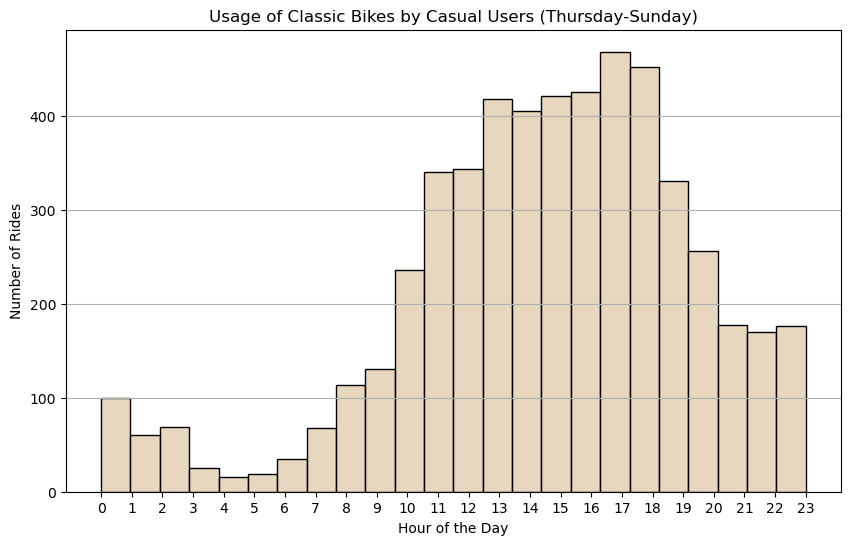

In [9]:
# Filter for only classic bikes used by casual users
classic_bikes_casual = data[(data['rideable_type'] == 'classic_bike') & (data['member_casual'] == 'casual')]

# Filter for Thursday, Friday, Saturday, Sunday
classic_bikes_casual['day_of_week'] = classic_bikes_casual['started_at'].dt.dayofweek
classic_bikes_casual_weekend = classic_bikes_casual[classic_bikes_casual['day_of_week'] >= 3]

# Extract hour of day
classic_bikes_casual_weekend['hour_of_day'] = classic_bikes_casual_weekend['started_at'].dt.hour

# Plotting histogram
plt.figure(figsize=(10, 6))
sns.histplot(classic_bikes_casual_weekend['hour_of_day'], bins=24, kde=False, color='#e0caa9')
plt.title('Usage of Classic Bikes by Casual Users (Thursday-Sunday)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

In [14]:
# Count the total number of rides starting at each station
start_counts_total = data['start_station_name'].value_counts()

# Count the total number of rides ending at each station
end_counts_total = data['end_station_name'].value_counts()

# Calculating discrepancy for each station
# discrepancy = absolute difference between starts and ends
station_discrepancy = start_counts_total.subtract(end_counts_total, fill_value=0).abs()

# Ranking stations by largest discrepancy
station_discrepancy_sorted = station_discrepancy.sort_values(ascending=False)

# Top 20 stations with largest discrepancy
top_20_discrepancy_stations = station_discrepancy_sorted.head(20)

top_20_discrepancy_stations



DuSable Lake Shore Dr & Monroe St        56.0
Wabash Ave & Grand Ave                   52.0
Clinton St & Madison St                  49.0
St. Clair St & Erie St                   48.0
Sedgwick St & Webster Ave                47.0
Michigan Ave & Oak St                    47.0
Columbus Dr & Randolph St                43.0
Southport Ave & Waveland Ave             42.0
LaSalle Dr & Huron St                    39.0
Wilton Ave & Belmont Ave                 39.0
Indiana Ave & Roosevelt Rd               36.0
Halsted St & Roscoe St                   36.0
Millennium Park                          35.0
DuSable Lake Shore Dr & Diversey Pkwy    34.0
Cityfront Plaza Dr & Pioneer Ct          34.0
Milwaukee Ave & Grand Ave                34.0
Streeter Dr & Grand Ave                  33.0
Michigan Ave & Washington St             33.0
Rush St & Hubbard St                     32.0
Kingsbury St & Kinzie St                 31.0
dtype: float64

In [15]:
# Extracting latitude and longitude for start stations
start_stations_lat_lng = data[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates()

# Extracting latitude and longitude for end stations
end_stations_lat_lng = data[['end_station_name', 'end_lat', 'end_lng']].drop_duplicates()
end_stations_lat_lng.columns = ['start_station_name', 'start_lat', 'start_lng']

# Combining start and end stations latitude and longitude
all_stations_lat_lng = pd.concat([start_stations_lat_lng, end_stations_lat_lng]).drop_duplicates()

# Filtering for the top 20 stations with largest discrepancy
top_20_stations_lat_lng = all_stations_lat_lng[all_stations_lat_lng['start_station_name'].isin(top_20_discrepancy_stations.index)]

top_20_stations_lat_lng

import folium

# Ensuring unique entries for each station
unique_top_20_stations_lat_lng = top_20_stations_lat_lng.drop_duplicates(subset=['start_station_name'])

# Creating a map centered around the general area of the stations
map_center_lat = unique_top_20_stations_lat_lng['start_lat'].mean()
map_center_lng = unique_top_20_stations_lat_lng['start_lng'].mean()
station_map = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=12)

# Adding markers for each station
for _, row in unique_top_20_stations_lat_lng.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name']
    ).add_to(station_map)
'''
# Saving the map to an HTML file
map_file_path = '/mnt/data/top_20_discrepancy_stations_map.html'
station_map.save(map_file_path)
'''
#map_file_path

station_map



In [16]:
station_discrepancy_sorted

DuSable Lake Shore Dr & Monroe St     56.0
Wabash Ave & Grand Ave                52.0
Clinton St & Madison St               49.0
St. Clair St & Erie St                48.0
Sedgwick St & Webster Ave             47.0
                                      ... 
Kedzie Ave & 24th St                   0.0
Kedzie Ave & 104th St                  0.0
State St & 76th St                     0.0
State St & 79th St                     0.0
Lincoln Ave & Roscoe St - Charging     0.0
Length: 1001, dtype: float64

In [17]:
# Recalculating discrepancy without absolute value
# Positive discrepancy: More rides ending than starting at the station
# Negative discrepancy: More rides starting than ending at the station
station_discrepancy_signed = start_counts_total.subtract(end_counts_total, fill_value=0)

# Sorting the discrepancies
station_discrepancy_sorted_signed = station_discrepancy_signed.sort_values()

# Top 10 stations with positive discrepancy
top_10_positive_discrepancy = station_discrepancy_sorted_signed.tail(10)

# Bottom 10 stations with negative discrepancy
bottom_10_negative_discrepancy = station_discrepancy_sorted_signed.head(10)

top_10_positive_discrepancy, bottom_10_negative_discrepancy



(Streeter Dr & Grand Ave                  33.0
 DuSable Lake Shore Dr & Diversey Pkwy    34.0
 Cityfront Plaza Dr & Pioneer Ct          34.0
 Millennium Park                          35.0
 Indiana Ave & Roosevelt Rd               36.0
 Halsted St & Roscoe St                   36.0
 LaSalle Dr & Huron St                    39.0
 Southport Ave & Waveland Ave             42.0
 Columbus Dr & Randolph St                43.0
 Wabash Ave & Grand Ave                   52.0
 dtype: float64,
 DuSable Lake Shore Dr & Monroe St   -56.0
 Clinton St & Madison St             -49.0
 St. Clair St & Erie St              -48.0
 Michigan Ave & Oak St               -47.0
 Sedgwick St & Webster Ave           -47.0
 Wilton Ave & Belmont Ave            -39.0
 Milwaukee Ave & Grand Ave           -34.0
 Michigan Ave & Washington St        -33.0
 Halsted St & Wrightwood Ave         -31.0
 Campbell Ave & North Ave            -30.0
 dtype: float64)

In [18]:
# Extracting the station names for the top and bottom 10 stations
top_10_station_names = top_10_positive_discrepancy.index
bottom_10_station_names = bottom_10_negative_discrepancy.index

# Filtering the latitude and longitude for these stations
top_10_stations_lat_lng = all_stations_lat_lng[all_stations_lat_lng['start_station_name'].isin(top_10_station_names)]
bottom_10_stations_lat_lng = all_stations_lat_lng[all_stations_lat_lng['start_station_name'].isin(bottom_10_station_names)]

# Ensuring unique entries for each station
top_10_stations_lat_lng_unique = top_10_stations_lat_lng.drop_duplicates(subset=['start_station_name'])
bottom_10_stations_lat_lng_unique = bottom_10_stations_lat_lng.drop_duplicates(subset=['start_station_name'])

# Creating a map centered around the general area of the stations
map_center_lat = all_stations_lat_lng['start_lat'].mean()
map_center_lng = all_stations_lat_lng['start_lng'].mean()
station_map_discrepancy = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=12)

# Adding blue markers for top 10 positive discrepancy stations
for _, row in top_10_stations_lat_lng_unique.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color="blue")
    ).add_to(station_map_discrepancy)

# Adding red markers for bottom 10 negative discrepancy stations
for _, row in bottom_10_stations_lat_lng_unique.iterrows():
    folium.Marker(
        location=[row['start_lat'], row['start_lng']],
        popup=row['start_station_name'],
        icon=folium.Icon(color="red")
    ).add_to(station_map_discrepancy)

station_map_discrepancy

